<img src="https://i.imgur.com/36sp6u2.png" align="middle"><br>
<img src="https://cdn.sstatic.net/Sites/stackoverflow/company/img/logos/so/so-logo.png" style="width:400px;height:80px;" align="middle"><br>
<div align=center><h3>Goal Number 5</h3></div>
<div align=center>Within this Notebook I will be exploring the distribution of salary, and investigate which will be the most well paid programming language, and by extension, the most well paid programming jobs. The objective here is to quantify, using the records given in the Stack Overflow survey, from which this project draws it's dataset (available @ : <a href="https://insights.stackoverflow.com/survey/">Stack Overflow Developer Survey</a>), the most well paid programming languages in the world.Once I have identified this, I will explore the satisfaction of these programmers, to assess the benefits and pitfalls of learning a language for monetary gain, versus the potential personal happiness, or lack thereof this may cause.</div>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import scatter_matrix
import plotly as pltly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.linear_model import LinearRegression
#init_notebook_mode(connected=True)
import pycountry
pltly.tools.set_credentials_file(username='JakeMurphDS1718', api_key='VzF5mDLdeJvs2Jt9e1yR')
%matplotlib inline 
# will be based on Work remote, jobsatisfaction, hoursworked, start time, auditory environment, career satisfaction
# job satisfaction etc, compare 2012-2017
mostUsedLanguages = pd.Series(['Java','Python','C','C++','Ruby','JavaScript','C#','PHP','SQL'])

surveyAnswers = pd.read_csv('C:/Users/jakem/Desktop/Data_Sets/survey_results_public.csv')

In [3]:
worldMap = {country.name: country.alpha3 for country in pycountry.countries}
worldMapDataList = []

for country in worldMap:
    worldMapData = {'Country': country, 'Code': worldMap[country], 'Total': (surveyAnswers.Country == country).sum(), 
                  '0-5k' : str(len(surveyAnswers[(surveyAnswers['Country']== country) & (surveyAnswers['Salary']<=5000)])),
                  '5-10k' : str(len(surveyAnswers[(surveyAnswers['Country']== country) & (surveyAnswers['Salary']>5000) & (surveyAnswers['Salary']<=10000)])),
                  '10-20k' : str(len(surveyAnswers[(surveyAnswers['Country']== country) & (surveyAnswers['Salary']>10000) & (surveyAnswers['Salary']<=20000)])),
                  '20-30k' : str(len(surveyAnswers[(surveyAnswers['Country']== country) & (surveyAnswers['Salary']>20000) & (surveyAnswers['Salary']<=35000)])),
                  '35-50k' : str(len(surveyAnswers[(surveyAnswers['Country']== country) & (surveyAnswers['Salary']>35000) & (surveyAnswers['Salary']<=50000)])),
                  '50-75k' : str(len(surveyAnswers[(surveyAnswers['Country']== country) & (surveyAnswers['Salary']>50000) & (surveyAnswers['Salary']<=75000)])),
                  '>75k' : str(len(surveyAnswers[(surveyAnswers['Country']== country) & (surveyAnswers['Salary']>75000)])),
                  'NA': str(len(surveyAnswers[(surveyAnswers['Country']== country) & (surveyAnswers['Salary'].isnull())]))}
    worldMapDataList.append(worldMapData)
    
df = pd.DataFrame(worldMapDataList) # creating panda object

In [4]:
df['firstVersion'] = df['Country'] + "<br>>75k : " + df['>75k'] + "<br>50-75k : " + df['50-75k'] \
                    + "<br>35-50k : " + df['35-50k'] + "<br>20-30k : " + df['20-30k'] + "<br>10-20k : " + df['10-20k'] \
                    + "<br>5-10k : " + df['5-10k'] + "<br>0-5k : " + df['0-5k'] + "<br>NA : " + df['NA'] 

data = [ dict(
        type = 'choropleth',
        locations = df['Code'],
        z = df['Total'],
        text = df['firstVersion'],
        colorscale = [[0,"rgb(0,100,0)"],[0.35,"rgb(34,139,34)"],[0.5,"rgb(50,205,50)"],\
            [0.6,"rgb(124,252,0)"],[0.7,"rgb(173,255,47)"],[1,"rgb(200,250,200)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Respondents<br>Thousands'),
      ) ]

layout = dict(
    title = '2017 Stackoverflow Job Satisfaction<br>Dataset Available @ \
            <a href="https://insights.stackoverflow.com/survey/">\
            Stack Overflow Annual Developer Survey</a>',
    geo = dict(
        showframe = False,
        showlakes = True,
        lakecolor = "rgb(55, 255, 255)",
        showcoastlines = True,
        projection = dict(
            type = 'orthographic'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False)

In [5]:
surveyAnswers = surveyAnswers.query('Salary>21')
salary = surveyAnswers['Salary'].unique()

In [6]:
surveyAnswers['Salary'].describe()

count     12855.000000
mean      56456.133016
std       39825.123531
min          24.332798
25%       26875.000000
50%       50000.000000
75%       80000.000000
max      197000.000000
Name: Salary, dtype: float64

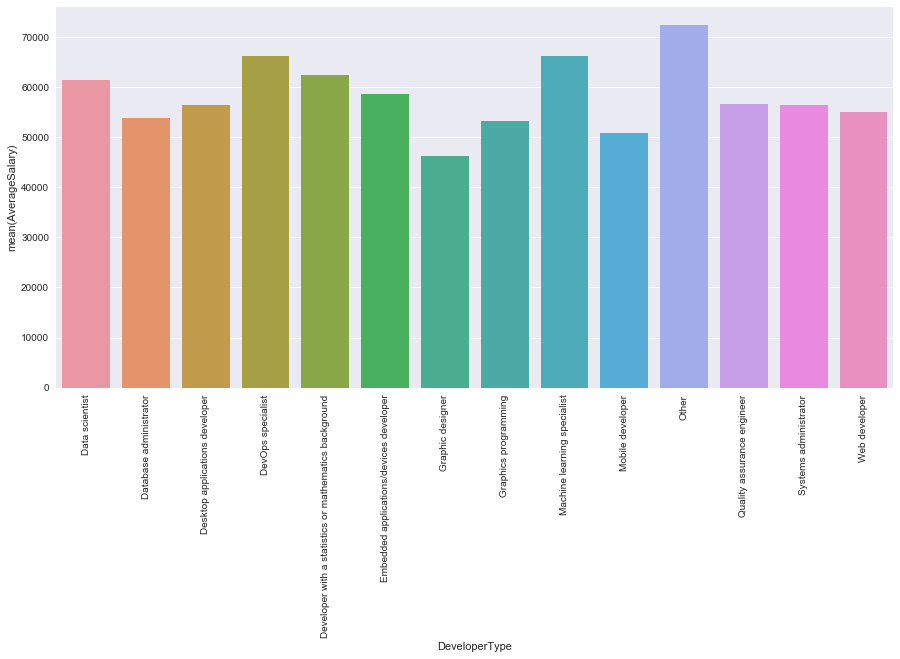

In [7]:
developerType = set()
#split needed as many developers answered multiple types
salary_avg_jobs = surveyAnswers['DeveloperType'].drop(surveyAnswers.loc[surveyAnswers['DeveloperType'].isnull()].index)
for jobs in salary_avg_jobs:
    for types in jobs.split(';'):
        developerType.add(types.strip())
developerType = sorted(list(developerType))

# reassign for further use, make sure no DeveloperType is null
salary_avg_jobs = surveyAnswers[surveyAnswers['DeveloperType'].notnull()]

# Prepare developer type index to organize the salary
devDict = {}
for index, dev in enumerate(developerType):
    devDict[dev] = index

# Organize the salary based on its job type
devSalaries = [[] for i in range(len(developerType))]
for index, jobs in salary_avg_jobs.iterrows():
    devlist = jobs['DeveloperType'].split(";")
    for d in devlist:
        devSalaries[devDict[d.strip()]].append(jobs['Salary'])

# Calculate the average salary for each job type
Salaries = []
for sal in devSalaries:
    Salaries.append(np.mean(sal))

# Construct the data frame
devSalaries = pd.DataFrame()
devSalaries["DeveloperType"] = developerType
devSalaries["AverageSalary"] = Salaries

# Plot
plt.subplots(figsize=(15,7))
sns.set_style("whitegrid")
sal = sns.barplot(x=devSalaries.DeveloperType, y=devSalaries.AverageSalary, orient = 1)
sal.set_xticklabels(devSalaries.DeveloperType, rotation=90)

<div>The above graph displays an arrangement of salaries with the jobs that particular developers are in. This allows a clear view at the relationship between a certain job position and the average salary individuals in these positions earn. The graph defines that a DevOps Specialist, and a Machine Learning Specialist are the most well compensated for their work in their respective fields. This superior income can be owed to the fact that these sectors are currently emerging and becoming more and more popular, while still being relatively unsaturated with experts. Similarly, desirable skills in this area have allowed individuals to Data Scientist, and Developers with statistics or mathematical backgrounds to jointly command the next highest income. Bridging outwards from these positions, the more common, saturated and contested positions command a progressively lower wage.</div>

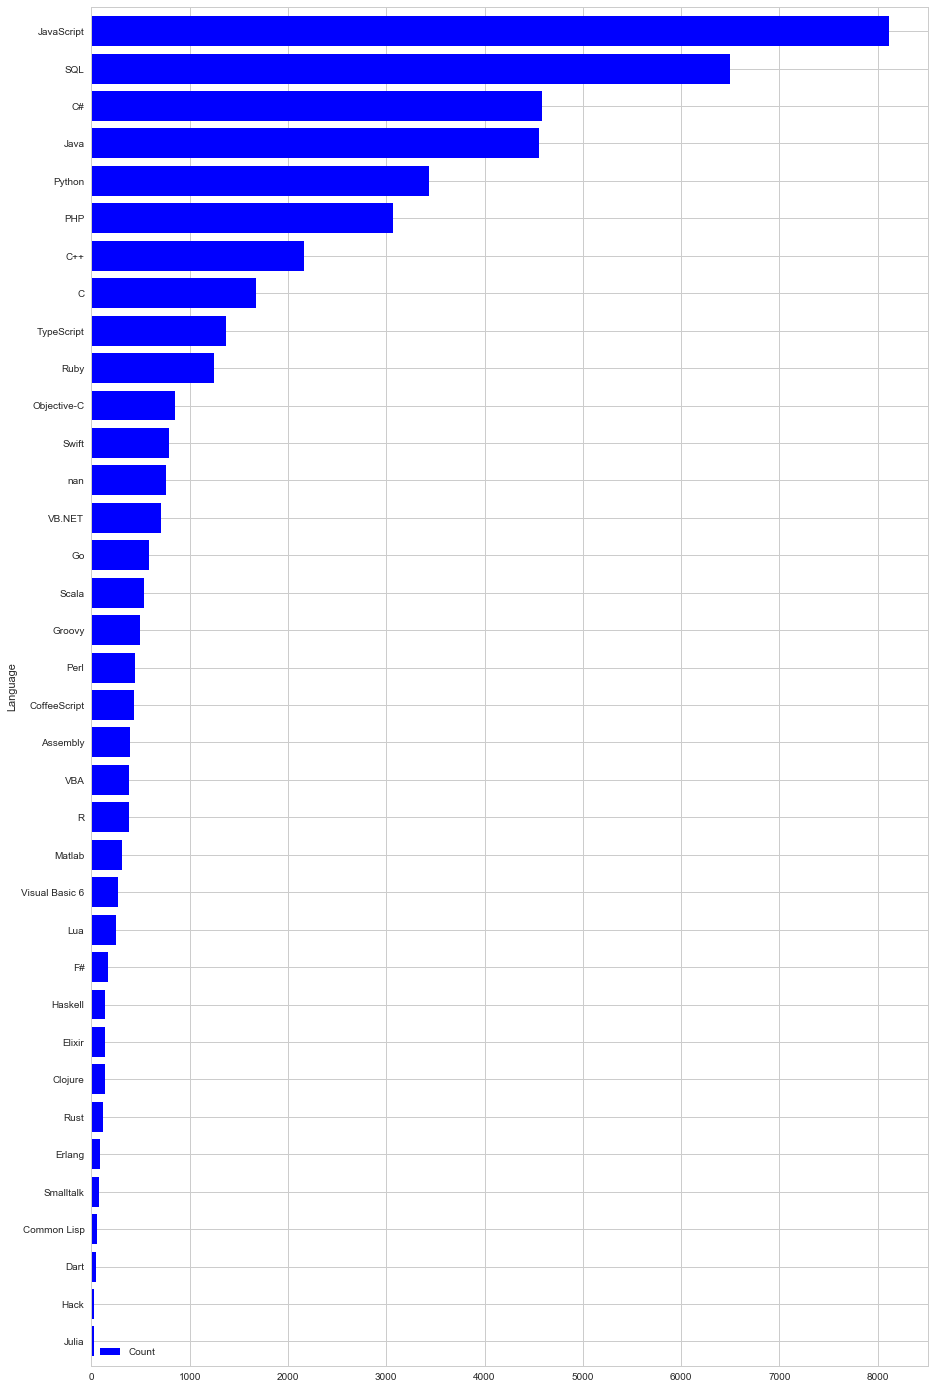

In [8]:
# Compile list of language found in survey
language = map((lambda x: str(x).split('; ')), 
               surveyAnswers['HaveWorkedLanguage'])
# Flatten the list
language = reduce((lambda x, y: x + y), language)
# Remove duplication
language = list(set(language))

colours = ['b', 'g', 'r', 'c', 'm', 'y', 'g' ]
# Count the language users
languageUser={}
for i in language:
    languageUser[i] = surveyAnswers['HaveWorkedLanguage'].apply(
        lambda x: i in str(x).split('; ')).value_counts()[1]

# Start plotting
lang = pd.DataFrame(list(languageUser.items()))
lang.columns = [['Language', 'Count']]
lang.set_index('Language', inplace=True)
lang.sort_values('Count', inplace=True)
lang.plot.barh(width=0.8, color=colours, figsize=(15,25))
plt.show()

<div>The above graph details the count and distribution of developers across all significant languages available in the programming world today. The results show the standards dominate the upper ranks of this graph, which a substantial portion of all respondents programming in them. This can be seen in javascript being used by at least (~8100/64000) 12.65% of all global respondents reporting that the language is in their repertoire, with a similar (~6400/64000) 10% of all respondents claiming to program in SQL. Joining these are of course Python, Java, C#, PHP and C++ as the top languages of the programming world.</div>

C:\Users\jakem\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning:

Mean of empty slice.

C:\Users\jakem\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars



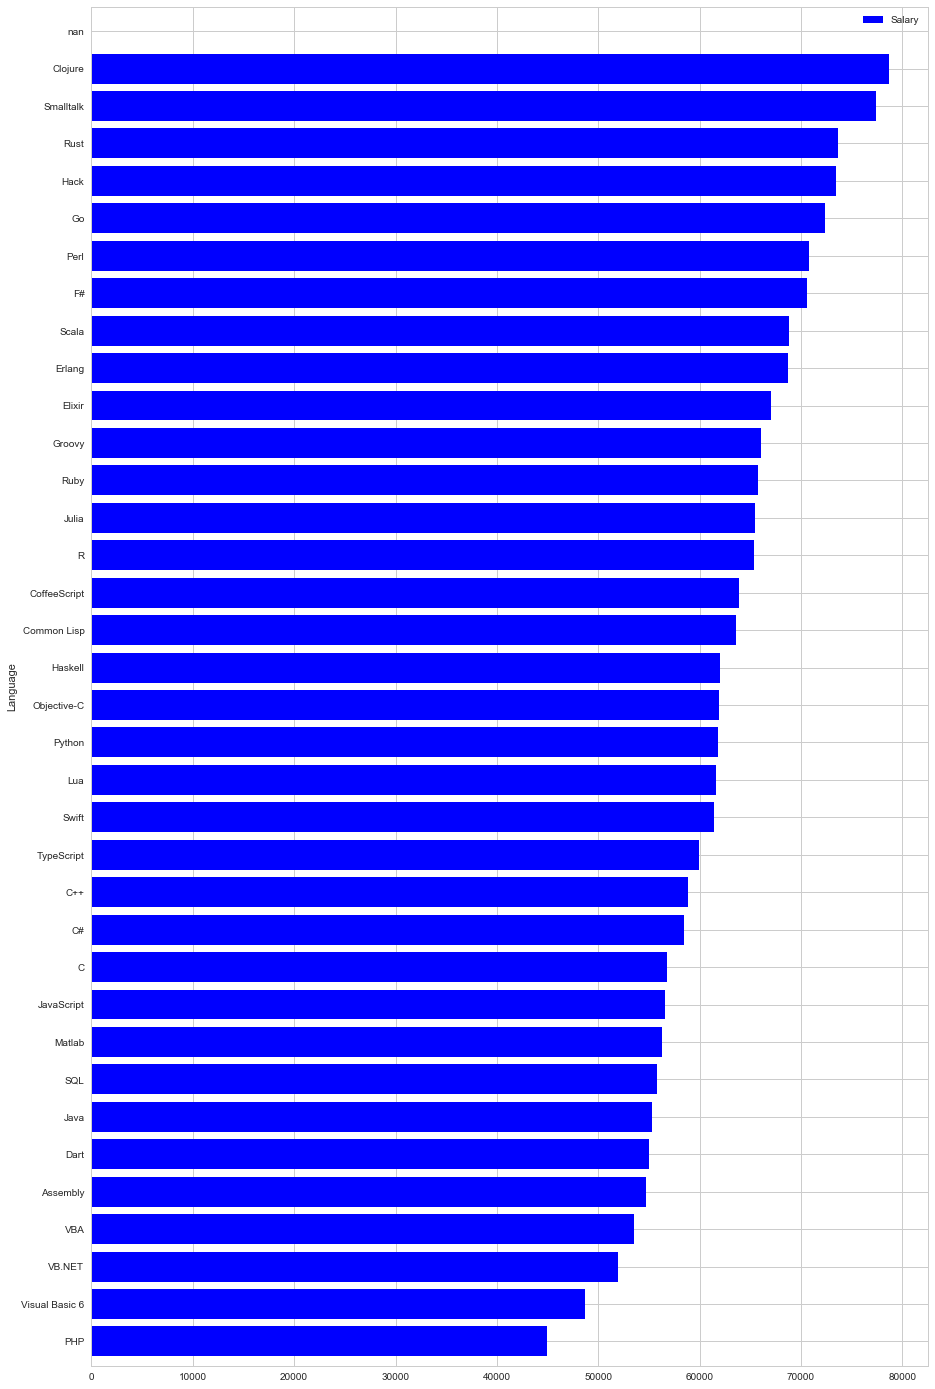

In [9]:
# Clean data, make sure no HaveWorkedLanguage is null
salary_avg_lang = surveyAnswers[surveyAnswers['HaveWorkedLanguage'].notnull()]

# Prepare developer type index to orgainze the salary
devDict = {}
for index, dev in enumerate(language):
    devDict[dev] = index

# Organize the salary based on its job type
devSalaries = [[] for i in range(len(language))]
for index, datum in salary_avg_lang.iterrows():
    devlist = datum['HaveWorkedLanguage'].split("; ")
    if not devlist:
        continue
    for d in devlist:
        devSalaries[devDict[d.strip()]].append(datum['Salary'])
        
# Calculate the average salary for each job type
Salaries = list(map(lambda x: np.mean(x), devSalaries))

# Construct the data frame
lang = pd.DataFrame()
lang["Language"] = language
lang["AverageSalary"] = Salaries
lang.columns = [['Language', 'Salary']]
lang.set_index('Language', inplace=True)
lang.sort_values('Salary', inplace=True)
lang.plot.barh(width=0.8, color=colours, figsize=(15,25))
plt.show()

<div>The above diagram displays that while there was a set list of languages that are the most popular in the world, when it comes to earnings, it is inversely related, again displaying that the more obscure and less saturated markets are the ones providing the most substantial reward, with a number of uncommon positions such as a Clojure, Smalltalk, Rust, Hack, F# etc earning as much as €20,000 more than a similarly skilled Java or SQL developers</div>

In [10]:
#create dataset with all variables to be explored
langReg = pd.DataFrame()
langReg["Language"] = language
langReg["AverageSalary"] = Salaries
langReg["CareerSatisfaction"] = surveyAnswers['CareerSatisfaction'] 
langReg["JobSatisfaction"] = surveyAnswers['JobSatisfaction']
langReg.columns = [['Language', 'Salary', 'CareerSatisfaction', 'JobSatisfaction']]

langReg["Language"] = langReg["Language"].replace('PHP', 0)
langReg["Language"] = langReg["Language"].replace('Visual Basic 6', 1)
langReg["Language"] = langReg["Language"].replace('VB.NET', 2)
langReg["Language"] = langReg["Language"].replace('VBA', 3)
langReg["Language"] = langReg["Language"].replace('Assembly', 4)
langReg["Language"] = langReg["Language"].replace('Dart', 5)
langReg["Language"] = langReg["Language"].replace('Java', 6)
langReg["Language"] = langReg["Language"].replace('SQL', 7)
langReg["Language"] = langReg["Language"].replace('Matlab', 8)
langReg["Language"] = langReg["Language"].replace('JavaScript', 9)
langReg["Language"] = langReg["Language"].replace('C', 10)
langReg["Language"] = langReg["Language"].replace('C#', 11)
langReg["Language"] = langReg["Language"].replace('C++', 12)
langReg["Language"] = langReg["Language"].replace('TypeScript', 13)
langReg["Language"] = langReg["Language"].replace('Swift', 14)
langReg["Language"] = langReg["Language"].replace('Lua', 15)
langReg["Language"] = langReg["Language"].replace('Python', 16)
langReg["Language"] = langReg["Language"].replace('Objective-C', 17)
langReg["Language"] = langReg["Language"].replace('Haskell', 18)
langReg["Language"] = langReg["Language"].replace('Common Lisp', 19)
langReg["Language"] = langReg["Language"].replace('CoffeeScript', 20)
langReg["Language"] = langReg["Language"].replace('R', 21)
langReg["Language"] = langReg["Language"].replace('Julia', 22)
langReg["Language"] = langReg["Language"].replace('Ruby', 23)
langReg["Language"] = langReg["Language"].replace('Groovy', 24)
langReg["Language"] = langReg["Language"].replace('Elixir', 25)
langReg["Language"] = langReg["Language"].replace('Erlang', 26)
langReg["Language"] = langReg["Language"].replace('Scala', 27)
langReg["Language"] = langReg["Language"].replace('F#', 28)
langReg["Language"] = langReg["Language"].replace('Perl', 29)
langReg["Language"] = langReg["Language"].replace('Go', 30)
langReg["Language"] = langReg["Language"].replace('Hack', 31)
langReg["Language"] = langReg["Language"].replace('Rust', 32)
langReg["Language"] = langReg["Language"].replace('Smalltalk', 33)
langReg["Language"] = langReg["Language"].replace('Clojure', 34)
langReg = langReg[langReg.Salary.notnull()]

In [11]:
#X = surveyAnswers['HomeRemote'].values[:,np.newaxis]
X = langReg['Language'].values[:,np.newaxis]
#, 'AssessJobRemote'
y = langReg['Salary'].values

model = LinearRegression()

model.fit(X, y)
###############################

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

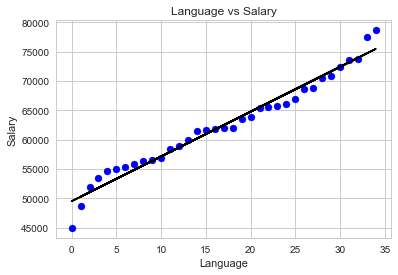

In [12]:
plt.scatter(X, y,color='b')

plt.title('Language vs Salary')  
plt.xlabel('Language')  
plt.ylabel('Salary')

plt.plot(X, model.predict(X),color='k')

plt.show()

<div><h1>Language vs Salary</h1>
<div>In the above linear regression graph we can see that there is an almost completely direct correlation between the obscurity and popularity of a programming language with its accompanying salary. This is understandable given the fact that the more popular a programming language is, the more an employer can afford to risk offering lower salaries, and conversely the more unknown or under-saturated a language's developer base is, the more an employee can afford the risk to demand from a prospective employer.</div></div>

In [13]:
langRegClean = langReg[langReg.CareerSatisfaction.notnull()]

#X = surveyAnswers['HomeRemote'].values[:,np.newaxis]
X = langRegClean['Language'].values[:,np.newaxis]
#, 'AssessJobRemote'
y = langRegClean['CareerSatisfaction'].values

model = LinearRegression()

model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

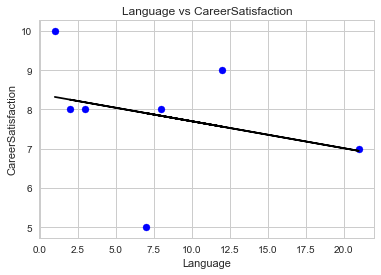

In [14]:
plt.scatter(X, y,color='b')

plt.title('Language vs CareerSatisfaction')  
plt.xlabel('Language')  
plt.ylabel('CareerSatisfaction')

plt.plot(X, model.predict(X),color='k')

plt.show()

<div><h1>Language vs Career Satisfaction</h1>
<div>In the above linear regression graph we can see that there is a very weak, but definite negative correlation between languages and the overall happiness of developers. While there are outliers that are happier than the more popular languages, there are also outliers that are significantly less happy than said languages. So while certain languages may provide a developer with a significantly better satisfaction in their career than the standard Javascript, SQL, PHP etc, such as Hack and Rust, R and Julia, it is much more consistently to a high level of satisfaction with these more common languages, potentially due to the access to and quality of documentation and discussion surrounding the more mainstream languages.</div></div>

In [15]:
langRegClean = langReg[langReg.JobSatisfaction.notnull()]

#X = surveyAnswers['HomeRemote'].values[:,np.newaxis]
X = langRegClean['Language'].values[:,np.newaxis]
#, 'AssessJobRemote'
y = langRegClean['JobSatisfaction'].values

model = LinearRegression()

model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

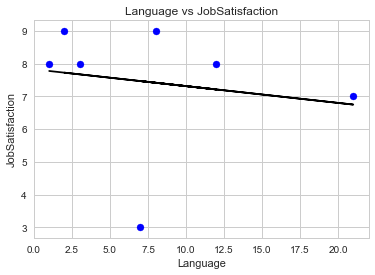

In [16]:
plt.scatter(X, y,color='b')

plt.title('Language vs JobSatisfaction')  
plt.xlabel('Language')  
plt.ylabel('JobSatisfaction')

plt.plot(X, model.predict(X),color='k')

plt.show()

<div><h1>Language vs Job Satisfaction</h1>
<div>
In the above linear regression graph we can see that there is a somewhat positive correlation between more obscure languages and the overall happiness of developers. While languages such as Hack and Rust, R and Julia are the most consistent in their high scoring job satisfaction, developers who are specialized in Javascript, SQL, PHP etc, are also predominantly satisfied with their current positions. It is merely the presence of the outliers in the data, which may be fake answers, that are skewing the overall sentiment, and effecting the angle of the linear correlation.</div></div>

In [17]:
###### this is a Support Vector Machine implemented using sample data to prove concept even though our own data 
###### does not suit the formats required

##### NOTE: Running this code will crash your pc and kill 8/23rds of a village of children in Africa




#from sklearn import svm

#def make_meshgrid(x, y, h=.02):
#    x_min, x_max = x.min() - 1, x.max() + 1
#    y_min, y_max = y.min() - 1, y.max() + 1
#    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                         np.arange(y_min, y_max, h))
#    return xx, yy


#def plot_contours(ax, clf, xx, yy, **params):
#    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#    Z = Z.reshape(xx.shape)
#    out = ax.contourf(xx, yy, Z, **params)
#    return out


#langRegForSVC = []

#for salary in langRegClean['Salary'] :
#    langRegForSVC.append(salary)
#langRegForSVC = [langReg['Salary'].values[:,np.newaxis], langReg['Language'].values[:,np.newaxis]] 

#X = langRegForSVC

#y = langReg['Language'].values[:-10]

# we create an instance of SVM, fit data. 
#C = 1.0  # SVM regularization parameter
#models = (svm.SVC(kernel='linear', C=C),
#          svm.LinearSVC(C=C),
#          svm.SVC(kernel='rbf', gamma=0.7, C=C),
#          svm.SVC(kernel='poly', degree=3, C=C))
#models = (clf.fit(X, y) for clf in models)

# title for the plots
#titles = ('SVC with linear kernel',
#          'LinearSVC (linear kernel)',
#          'SVC with RBF kernel',
#          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
#fig, sub = plt.subplots(2, 2)
#plt.subplots_adjust(wspace=0.4, hspace=0.4)

#X0, X1 = X['Salary'], X['Language']
#xx, yy = make_meshgrid(X0, X1)

#for clf, title, ax in zip(models, titles, sub.flatten()):
#    plot_contours(ax, clf, xx, yy,
#                  cmap=plt.cm.coolwarm, alpha=0.8)
#    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
#    ax.set_xlim(xx.min(), xx.max())
#    ax.set_ylim(yy.min(), yy.max())
#    ax.set_xlabel('Sepal length')
#    ax.set_ylabel('Sepal width')
#    ax.set_xticks(())
#    ax.set_yticks(())
#    ax.set_title(title)

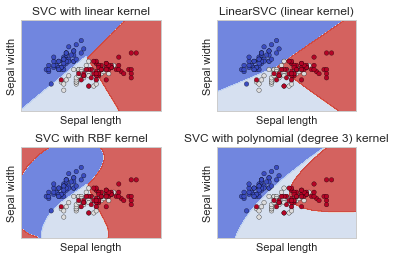

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import data
iris = datasets.load_iris()

X = iris.data[:, :2]
y = iris.target

C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [19]:
###### this is a Support Vector Machine implemented using sample data to prove concept even though our own data 
###### does not suit the formats required
#import pandas as pd
#import numpy as np
#from sklearn.svm import SVR
#import matplotlib.pyplot as plt

#langRegClean = pd.read_csv('C:/Users/jakem/Desktop/Data_Sets/survey_results_public.csv')
#langRegClean = langRegClean[langRegClean.Salary.notnull()]
# #############################################################################
# Generate sample data
#X = np.sort(langRegClean['Salary'].values[:, np.newaxis])
#y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
#y[::5] += 3 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)
#y_rbf = svr_rbf.fit(X, y).predict(X)
#y_lin = svr_lin.fit(X, y).predict(X)
#y_poly = svr_poly.fit(X, y).predict(X)

# #############################################################################
# Look at the results
#lw = 2
#plt.scatter(X, y, color='darkorange', label='data')
#plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
#plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
#plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
#plt.xlabel('data')
#plt.ylabel('target')
#plt.title('Support Vector Regression')
#plt.legend()
#plt.show()

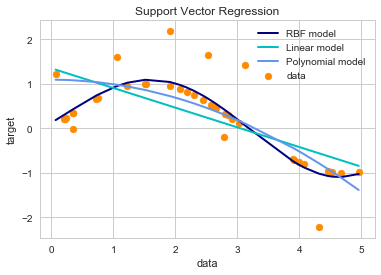

In [20]:
###### this is a Support Vector Machine implementing regression using random data to prove concept. Our own data 
###### does not suit the formats required and figuring out the formatting is far too time consuming at this stage
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

# #############################################################################
# Look at the results
lw = 2
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()